## Importing dataset and libs

In [ ]:
replays = pd.read_csv('../data/starcraft.csv')

In [1]:
import pandas as pd
import numpy as np
import math
from functools import reduce


import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("ggplot")
import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from starcraft_functions import plot_confusion_matrix

In [2]:
replays.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,...,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilityUsed,MaxTimeStamp
0,52,5,27.0,10.0,3000.0,143.7180,0.003515,0.000220,0.000055,0.000110,...,0.004849,32.6677,40.8673,4.7508,0.000220,0.001397,0.000047,0.0,0.000000,127448
1,55,5,23.0,10.0,5000.0,129.2322,0.003304,0.000259,0.000069,0.000294,...,0.004307,32.9194,42.3454,4.8434,0.000381,0.001194,0.000087,0.0,0.000208,57812
2,56,4,30.0,10.0,200.0,69.9612,0.001101,0.000336,0.000042,0.000294,...,0.002926,44.6475,75.3548,4.0430,0.000231,0.000745,0.000063,0.0,0.000189,95360
3,57,3,19.0,20.0,400.0,107.6016,0.001034,0.000213,0.000011,0.000053,...,0.003783,29.2203,53.7352,4.9155,0.000202,0.000426,0.000075,0.0,0.000384,93852
4,58,3,32.0,10.0,500.0,122.8908,0.001136,0.000327,0.000039,0.000000,...,0.002368,22.6885,62.0813,9.3740,0.000289,0.001174,0.000077,0.0,0.000019,51936


## Dataset and research question

**Name**: StarCraft II Replay Analysis<br>
**Link**: https://www.kaggle.com/sfu-summit/starcraft-ii-replay-analysis/home<br>
**Domain**: Gaming<br>
**Context**: This dataset is an aggregate of the screen-fixations from screen movements of StarCraft 2 replay files.<br>
**Size**: 3395 rows<br>
**Motivation**: In the past i played rts games like starcraft 2 and age of empires 2. Later i also
enjoyed watching the tournaments, and videos of old tournaments. Now i sporadically watch
videos of rts games. I am always intrigued by the skills that pro players acquire. I found the
dataset by just scrolling through the kaggle datasets.


## Feature explanation

PAC: Perception Action Cycle<br>
A PAC basically consists of a shift of the screen to a new location for some time, followed by at least one action (typically 4-6), and then a shift to some other location

| Feature       | Description   |
| ------------- |:-------------:|
| GameID        | Unique ID for each game |
| LeagueIndex   | 1-8 for Bronze, Silver, Gold, Diamond, Master, GrandMaster,Professional leagues      |
| Age           | Real live age of player      |
| HoursPerWeek   | Hours spent playing per week      |
| TotalHours | Total hours spent playing      |
| APM   | Actions per minute      |
| SelectByHotkeys | Number of unit selections made using hotkeys per timestamp      |
| AssignToHotkeys   | Number of units assigned to hotkeys per timestamp      |
| UniqueHotkeys | Number of unique hotkeys used per timestamp  |
| MinimapAttacks   | Number of attack actions on minimal per timestamp      |
| MinimapRightClicks | Number of right-clicks on minimal per timestamp      |
| NumberOfPACs   | Number of PACs per timestamp      |
| GapBetweenPACs | Mean duration between PACs (milliseconds)      |
| ActionLatency   | Mean latency from the onset of PACs to their first action (milliseconds)      |
| ActionsInPAC | Mean number of actions within each PAC      |
| TotalMapExplored   | Number of 24x24 game coordinate grids viewed by player per timestamp      |
| WorkersMade | Number of SCVs, drones, probes trained per timestamp    |
| UniqueUnitsMade | Unique units made per timestamp    |
| ComplexUnitsMade | Number of ghosts, investors, and high templars trained per timestamp     |
| ComplexAbilityUsed | Abilities requiring specific targeting instructions used per timestamp      |
| MaxTimeStamp | Time stamp of game's last recorded event |


## Research question & plan

**How can i predict the league index for a replay analysis?**

**Cleaning**
During some discovery of the dataset i didn’t came across any problematic data quality<br>
violations. I do have to fix some formats, like change age from 23.0 -> 23.<br>
When i was given the advice to combine some of the higher leagues due to the data amount<br>
those leagues, i checked out the league index of the replays, and this confirmed the expectations see below<br>

**features**
Some features are maybe a bit redundant. I’m considering combining combining some data.<br>
Although i wanna start out without combining these.<br>

SelectByHotkeys: Number of unit selections made using hotkeys per timestamp<br>
AssignToHotkeys: Number of units assigned to hotkeys per timestamp<br>
UniqueHotkeys: Number of unique hotkeys used per timestamp<br>

These 3 features could be a ‘HotkeyBehaviour’ score.<br>

MinimapAttacks: Number of attack actions on minimal per timestamp MinimapRightClicks:<br>
Number of right-clicks on minimal per timestamp<br>

These 2 could be a ‘MinimapBehaviour’ score.<br>

**algorithms**
When i follow the sci-kit cheat sheet, i’m ending up at Linear SVC. If this doesn’t work i can<br>
try KNeighbors Classifier, and after that SVC and Ensemble Classifiers. I am planning to try<br>
all of these.<br>

## Cleaning

Using the describe function i quickly found that there was a player with a very unrealistic amount of total hours (1 million). this is more hours thab the game exists, so i am removing him/her from the records

In [3]:
replays = replays[replays['TotalHours'] != 1000000]

replays.dropna(inplace=True)
replays.isnull().values.any()

replays.describe()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,...,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilityUsed,MaxTimeStamp
count,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,...,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000,3337.000000
mean,4719.426131,4.120467,21.651483,15.907102,661.039257,114.525764,0.004017,0.000364,0.000058,0.000094,...,0.003433,40.717594,64.218000,5.266780,0.000282,0.001031,0.000085,0.000060,0.000142,83748.656877
std,2657.307846,1.448307,4.206512,11.965468,856.348806,48.032308,0.004715,0.000210,0.000038,0.000159,...,0.000965,17.058352,19.034036,1.500796,0.000086,0.000520,0.000025,0.000112,0.000266,33612.702540
min,52.000000,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,...,0.000679,6.666700,24.632600,2.038900,0.000091,0.000077,0.000020,0.000000,0.000000,25224.000000
25%,2423.000000,3.000000,19.000000,8.000000,300.000000,79.229400,0.001244,0.000202,0.000032,0.000000,...,0.002743,29.328700,50.929400,4.261500,0.000224,0.000682,0.000068,0.000000,0.000000,60116.000000
50%,4787.000000,4.000000,21.000000,12.000000,500.000000,107.067600,0.002444,0.000349,0.000053,0.000039,...,0.003376,37.060500,61.303300,5.086800,0.000269,0.000904,0.000082,0.000000,0.000021,81044.000000
75%,6995.000000,5.000000,24.000000,20.000000,800.000000,140.090400,0.004938,0.000493,0.000078,0.000114,...,0.004003,48.512000,74.032800,6.027500,0.000324,0.001258,0.000099,0.000087,0.000182,102156.000000
max,9271.000000,7.000000,44.000000,168.000000,25000.000000,389.831400,0.043088,0.001648,0.000338,0.003019,...,0.007971,237.142900,176.372100,18.558100,0.000832,0.005149,0.000202,0.000902,0.003084,388032.000000


## LeagueIndex spread

Text(0,0.5,'Amount of replays')

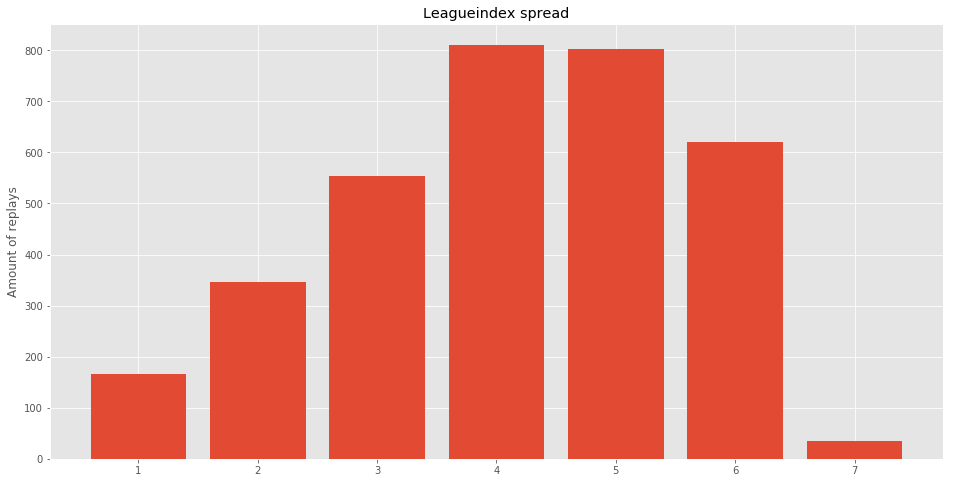

In [4]:
plt.figure(figsize=(16, 8));

leagueCounts = replays['LeagueIndex'].value_counts().sort_index()

labels = leagueCounts.index.values.tolist()
y_pos = np.arange(len(labels))

plt.bar(y_pos, leagueCounts, align='center', alpha=1)
plt.xticks(y_pos, labels)

plt.title('Leagueindex spread')
plt.ylabel('Amount of replays')


## Combining LeagueIndexes

After seeing that the data isn't very much equally distributed per league, i decided to merge the 2 highest leages and the 2 lowest leagues. <br>
The result of combining there leagues is that the data should be equally enough distributed per league to make classifications

Text(0,0.5,'Amount of replays')

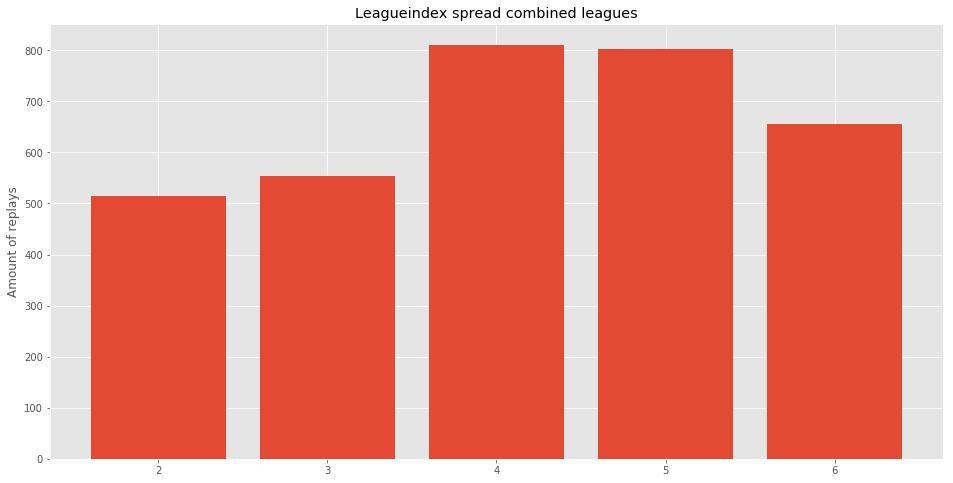

In [5]:
replays.loc[replays['LeagueIndex'] == 1, 'LeagueIndex'] = 2
replays.loc[replays['LeagueIndex'] == 7, 'LeagueIndex'] = 6

leagueCounts = replays['LeagueIndex'].value_counts().sort_index()
labels = leagueCounts.index.values.tolist()
y_pos = np.arange(len(labels))

plt.figure(figsize=(16, 8));
plt.bar(y_pos, leagueCounts, align='center', alpha=1)
plt.xticks(y_pos, labels)
plt.title('Leagueindex spread combined leagues')
plt.ylabel('Amount of replays')

# Exploring the impact of the features on the LeagueIndex score

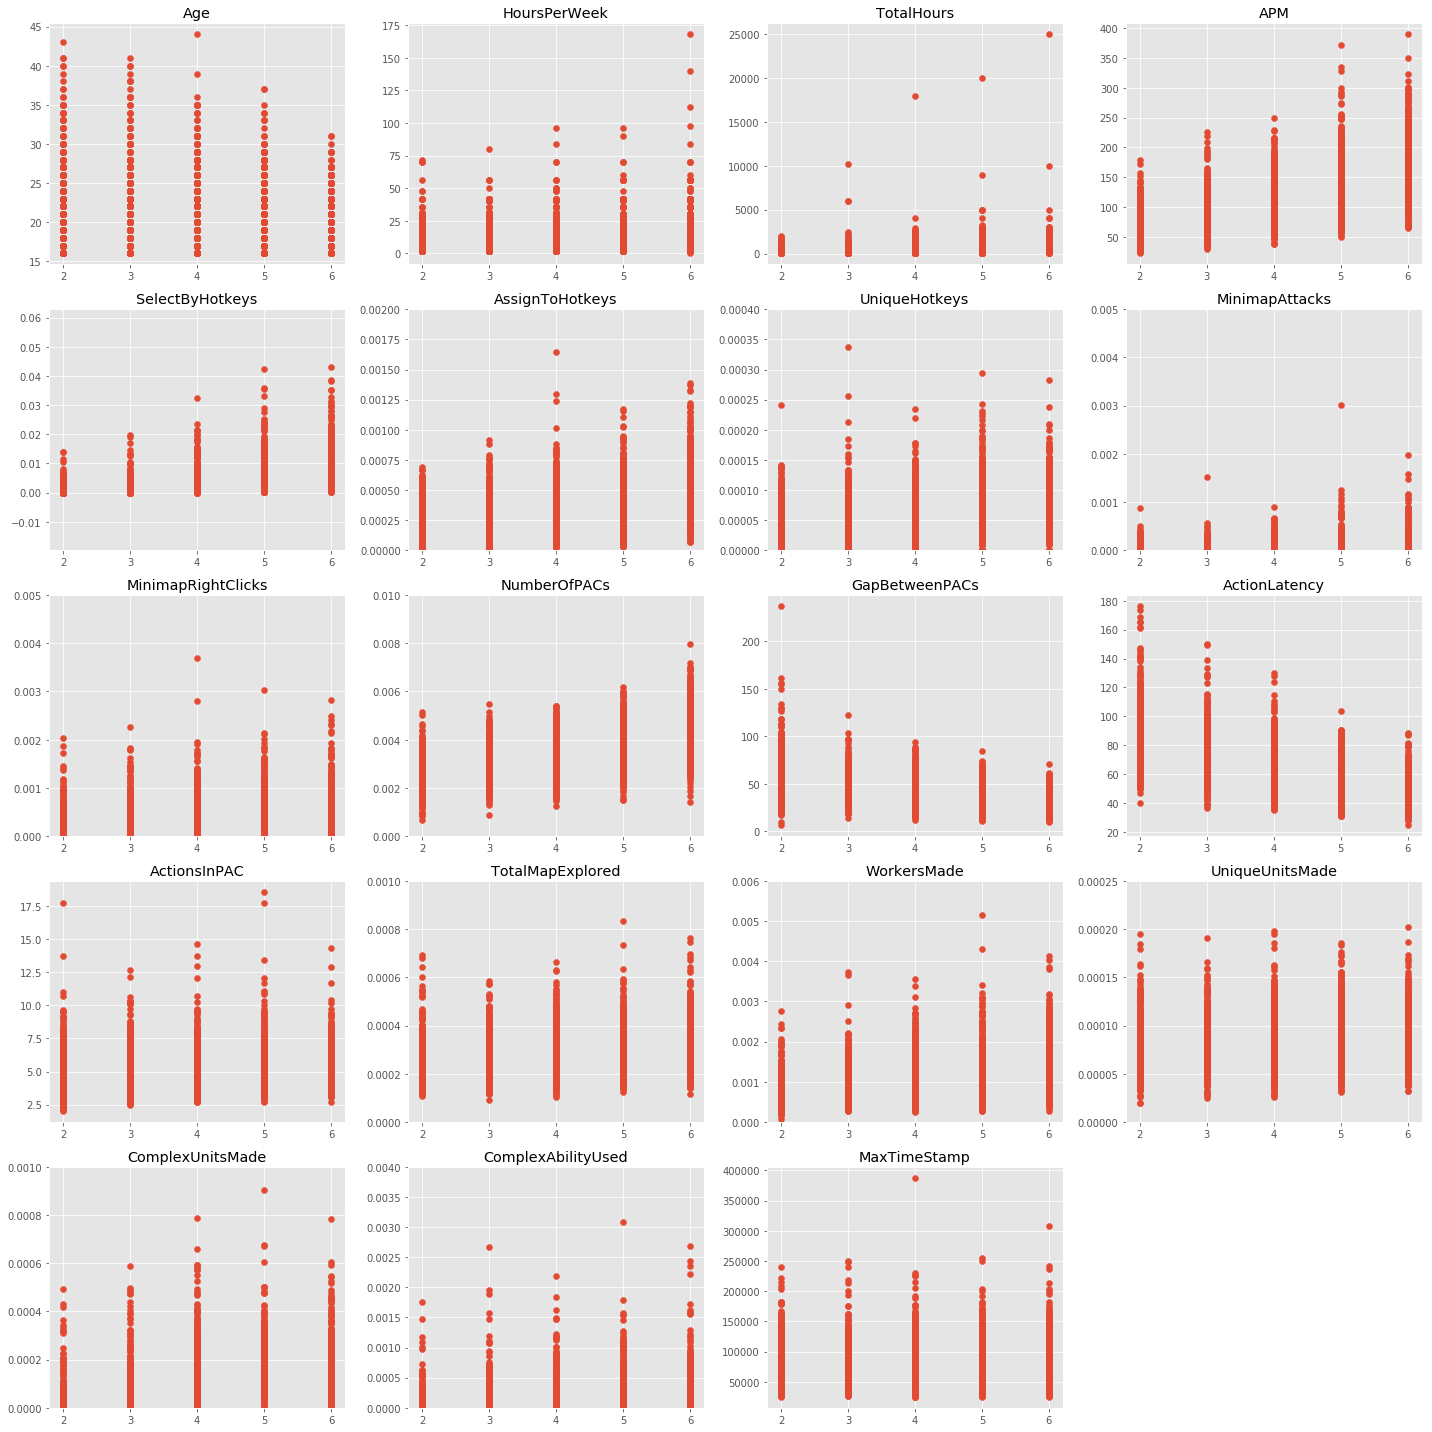

In [6]:
plt.figure(figsize=(20, 20))
graphs = ['Age', 'HoursPerWeek', 'TotalHours', 'APM', 'SelectByHotkeys', 'AssignToHotkeys', 
          'UniqueHotkeys', 'MinimapAttacks', 'MinimapRightClicks', 'NumberOfPACs', 'GapBetweenPACs', 
          'ActionLatency', 'ActionsInPAC', 'TotalMapExplored', 'WorkersMade', 'UniqueUnitsMade', 'ComplexUnitsMade',
         'ComplexAbilityUsed', 'MaxTimeStamp']
index = 0
for  graph in graphs:
    plt.subplot(5, 4, index + 1)
    plt.title(graph)
    plt.scatter(replays.LeagueIndex, replays[graph])
    plt.xticks([2, 3, 4, 5, 6])
        
    if(graph == 'ComplexAbilityUsed'):
        plt.ylim([0.0,0.004])
    if(graph == 'ComplexUnitsMade' or graph == 'TotalMapExplored'):
        plt.ylim([0.0,0.001])
    if(graph == 'UniqueUnitsMade'):    
        plt.ylim([0.0,0.00025])
    if(graph == 'WorkersMade'):     
        plt.ylim([0.0,0.006])
    if(graph == 'NumberOfPACs'):
        plt.ylim([0.0,0.010])
    if(graph == 'MinimapRightClicks' or graph == 'MinimapAttacks'):
        plt.ylim([0.0,0.005])
    if(graph == 'UniqueHotkeys'):
        plt.ylim([0.0,0.0004])
    if(graph == 'AssignToHotkeys'):
        plt.ylim([0.0,0.002])
        
        
    index += 1
plt.tight_layout()

## Feature selection / combining

Using linear regression i can find ouit which features 

0.552729886843684


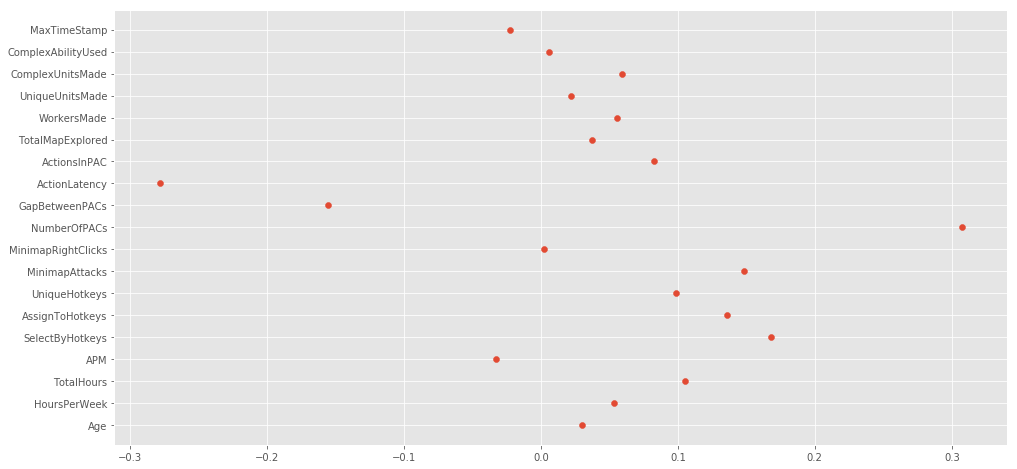

In [7]:
X_train, X_test, y_train, y_test = train_test_split(replays.iloc[:, 2:].values, replays.iloc[:, 1].values, test_size=0.25, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
f_train = scaler.transform(X_train)
f_test = scaler.transform(X_test)

labels = replays.iloc[:, 2:].columns.values

reg = LinearRegression()
reg.fit(f_train, y_train)

r_square = reg.score(f_test, y_test)
print(r_square)
coefficients = list(zip(labels, reg.coef_))

plt.figure(figsize=(16, 8));
plt.scatter(reg.coef_, labels);


In [20]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
    plt.yticks(range(len(corr.columns)), corr.columns);

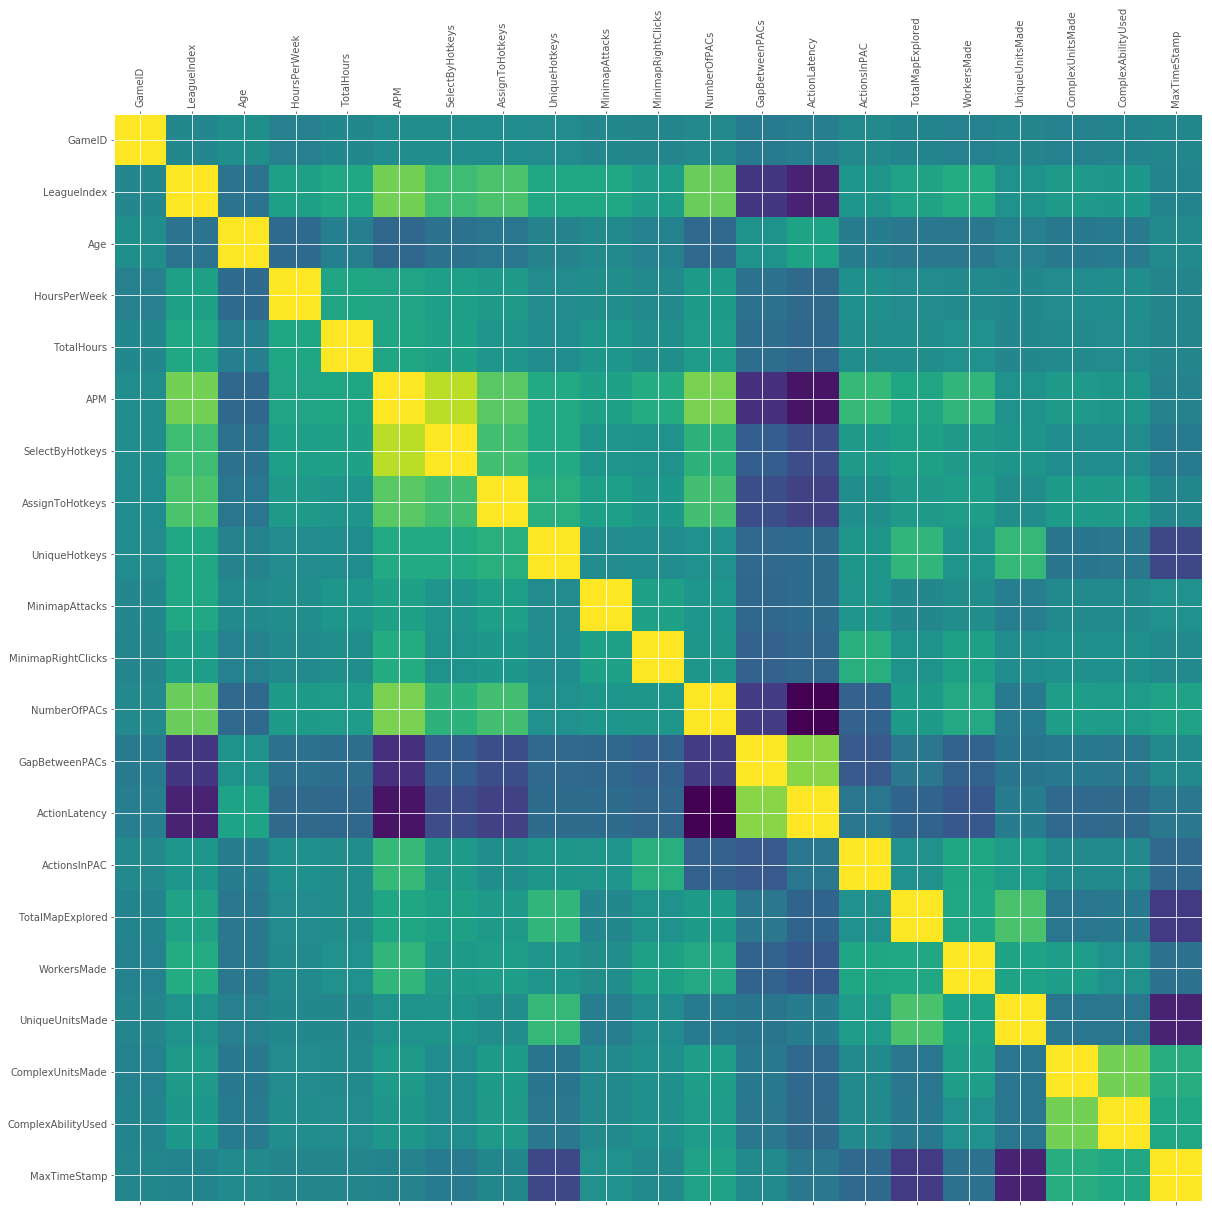

In [21]:
plot_corr(replays, 20)

<h4>Combining features?</h4>
During exploration i thought of combining features because they might be very correlated.<br>

I expected that SelectbyHotkeys, AssignToHotkeys and UniqueHotkeys would be very correlated. but this doesn't seem to be the case<br>
The same goess for MinimapRightClicks and MinimapAttacks<br>
Combining these features doesn't seem like a good choice

<h4>GapBetweenPACs and ActionLatency</h4> 
These 2 features seem to be the best predictors for the LeagueIndex.<br>
Both seem quite comprehensible, since they both reflect a lot of what is going on on the keyboard.<br>
Watching starcraft plays i already discovered that good players utilize their keyboard to the fullest<br> 



<h4>MaxTimeStamp</h4>
MaxTimeStamp has a lot of correlation with UniqueUnitsMade, which was to be expected.<br> 
The unique units start to become more easily accesable once the player has build up his base and more resources are flowing in, next to that, unique units usually have some pre-requests<br>
TotalMapExplored and UniqueUnitsMade are also very correlated with MaxTimeStamp. 



# Predicting league index

## Linear Support Vector Machines

The first step in the sci-kit algorithm cheat sheet is Linear SCV.<br>

The random state 0 is used to prevcen t
Im using KFold Cross validation to prove that overfitting is prevented.<br>
The amount of folds uesd is 5 (typical, default will change to 5 in version 0.22)<br>
Test set size is 25%<br>

In [22]:
X = np.array(list(replays.iloc[:, 2:].values))
y = np.array(list(replays.iloc[:, 1].values))

kf = KFold(n_splits=5, shuffle=True, random_state=0)

accuracy_scores_linear_svm = []
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    #Create train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Standardize data
    scaler = preprocessing.StandardScaler().fit(X_train)
    f_train = scaler.transform(X_train)
    f_test = scaler.transform(X_test)
    
    #Create model
    clf = SVC(random_state=0, tol=1e-5, kernel='linear')
    clf.fit(f_train, y_train)
    pred = clf.predict(f_test)
    
    #Check accuracy
    acc = accuracy_score(pred, y_test)
    accuracy_scores_linear_svm.append(acc)
    
print('accuracy score per set', accuracy_scores_linear_svm) 
linearsvm_accuracy = reduce(lambda x, y: x + y, accuracy_scores_linear_svm) / len(accuracy_scores_linear_svm)
print('average accuracy score: ', linearsvm_accuracy)

accuracy score per set [0.4655688622754491, 0.4505988023952096, 0.46026986506746626, 0.4542728635682159, 0.48425787106446777]
average accuracy score:  0.4629936528741617


## KNNeighborsClassifier

The second step in the scikit alogirthm cheat sheet is k-nearest neighbors<br>


In [23]:
X = np.array(list(replays.iloc[:, 2:].values))
y = np.array(list(replays.iloc[:, 1].values))

kf = KFold(n_splits=5, shuffle=True, random_state=0)

accuracy_scores_kneighbor = []
for train_index, test_index in kf.split(X):
    
    #Create train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Standardize data
    scaler = preprocessing.StandardScaler().fit(X_train)
    f_train = scaler.transform(X_train)
    f_test = scaler.transform(X_test)
    
    #Create model
    knn = KNeighborsClassifier(n_neighbors=40)
    knn.fit(f_train, y_train)
    accuracy_scores_kneighbor.append(knn.score(f_test, y_test))
    
print('accuracy score per set', accuracy_scores_kneighbor)
kneighbor_accuracy = reduce(lambda x, y: x + y, accuracy_scores_kneighbor) / len(accuracy_scores_kneighbor)
print('average accuracy score: ', kneighbor_accuracy)

accuracy score per set [0.4655688622754491, 0.42065868263473055, 0.4047976011994003, 0.42128935532233885, 0.4272863568215892]
average accuracy score:  0.4279201716507016


### finding perfect n_neighbors

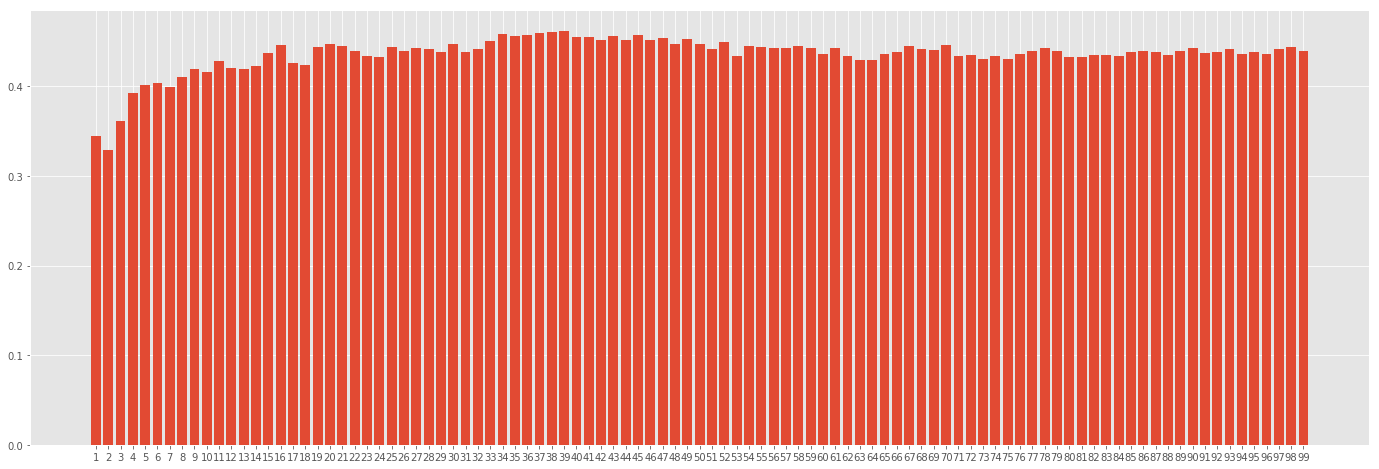

In [24]:
X_train, X_test, y_train, y_test = train_test_split(replays.iloc[:, 2:].values, replays.iloc[:, 1].values, test_size=0.25, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
f_train = scaler.transform(X_train)
f_test = scaler.transform(X_test)

results = []
labels = []
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(f_train, y_train)
#     print(knn.score(f_test, y_test))
    results.append(knn.score(f_test, y_test))
    labels.append(i)
y_pos = np.arange(len(labels))
plt.figure(figsize=(24, 8));
plt.bar(y_pos, results, align='center', alpha=1)
plt.xticks(y_pos, labels);    

In the beginning the results get better when the min amount of neighbors increases. <br>
Quickly the accuracy scores stay around the same when more min neighbors are added. <br>
The peak seaems to be around a minimum of 40 neighbors

## Support Vector Machines

In [8]:
X = np.array(list(replays.iloc[:, 2:].values))
y = np.array(list(replays.iloc[:, 1].values))

kf = KFold(n_splits=5, shuffle=True, random_state=0)

accuracy_scores_svm = []
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    
    #Create train and test set
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Standardize data
    scaler = preprocessing.StandardScaler().fit(X_train)
    f_train = scaler.transform(X_train)
    f_test = scaler.transform(X_test)
    
    #Create model
    clf = SVC(random_state=0, tol=1e-5, kernel='rbf')
    clf.fit(f_train, y_train)
    pred = clf.predict(f_test)
    
    #Check accuracy
    acc = accuracy_score(pred, y_test)
    accuracy_scores_svm.append(acc)
    
print('accuracy score per set', accuracy_scores_svm)
svm_accuray = reduce(lambda x, y: x + y, accuracy_scores_svm) / len(accuracy_scores_svm)
print('average accuracy score: ', svm_accuray)

accuracy score per set [0.46407185628742514, 0.4565868263473054, 0.4542728635682159, 0.4362818590704648, 0.46476761619190404]
average accuracy score:  0.455196204293063


# Ensemble Classifiers

https://scikit-learn.org/stable/modules/ensemble.html<br>
'The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.'<br>

## Random Forests

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier<br>
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(list(replays.iloc[:, 2:].values)), replays.iloc[:, 1].values, test_size=0.25, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
f_train = scaler.transform(X_train)
f_test = scaler.transform(X_test)

m = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=0)
m.fit(f_train, y_train)
pred = m.predict(f_test)
acc = accuracy_score(pred, y_test)
print(acc)

0.4502994011976048


## Decision tree

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(list(replays.iloc[:, 2:].values)), replays.iloc[:, 1].values, test_size=0.25, random_state=0)

tree = DecisionTreeClassifier(splitter='best')
tree.fit(X_train, y_train)
dectree_accuracy = tree.score(X_test, y_test)
print(dectree_accuracy)

0.37005988023952097


# Testing algorithms on selected features

In [11]:
test_size = 0.2

f1 = replays.ActionLatency.values
f2 = replays.GapBetweenPACs.values
f3 = replays.NumberOfPACs.values
f4 = replays.SelectByHotkeys.values
f5 = replays.APM.values

X_train, X_test, y_train, y_test = train_test_split(np.array(list(zip(f1, f2, f3, f4, f5))), replays.iloc[:, 1].values, test_size=test_size, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
f_train = scaler.transform(X_train)
f_test = scaler.transform(X_test)

#linear svm
clf = SVC(random_state=0, tol=1e-5, kernel='linear')
clf.fit(f_train, y_train)
pred = clf.predict(f_test)
#Check accuracy
acc = accuracy_score(pred, y_test)
print('linear svm: ', acc)

#svm
clf = SVC(random_state=0, tol=1e-5, kernel='rbf')
clf.fit(f_train, y_train)
pred = clf.predict(f_test)
#Check accuracy
acc = accuracy_score(pred, y_test)
print('svm: ', acc)

# knn
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(f_train, y_train)
print('knn: ', knn.score(f_test, y_test))

linear svm:  0.44011976047904194
svm:  0.42664670658682635
knn:  0.4341317365269461


##  Metrics

When a classification of a LeagueIndex is wrong, the player is placed to low or to high league for his/her skill level<br>
- When a player is placed to low, the player will have an easy time, and the oppenents will have a harder time 
- When a player is placed to high, they player will have a hard time winning games and might get frustrated quickly<br>


There is also an amount of wrongness in the wrong prediction. The amount of leagues away from the class label shows this.

Normalized confusion matrix
[[0.66923077 0.08461538 0.2        0.04615385 0.        ]
 [0.32638889 0.13888889 0.45833333 0.0625     0.01388889]
 [0.13043478 0.10144928 0.4589372  0.26086957 0.04830918]
 [0.02617801 0.02094241 0.28272251 0.39790576 0.27225131]
 [0.         0.         0.0797546  0.33128834 0.58895706]]


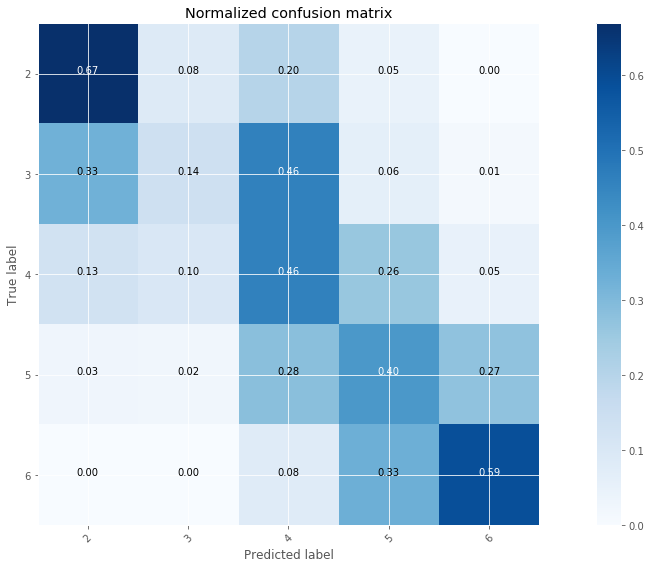

In [8]:
X_train, X_test, y_train, y_test = train_test_split(replays.iloc[:, 2:].values, replays.iloc[:, 1].values, test_size=0.25, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
f_train = scaler.transform(X_train)
f_test = scaler.transform(X_test)

#get the results from linear svm
clf_lsvc = SVC(random_state=0, tol=1e-5, kernel='linear')
clf_lsvc.fit(f_train, y_train)
pred_lsvc = clf_lsvc.predict(f_test)

cnf_matrix = confusion_matrix(y_test, pred_lsvc)
plt.figure(figsize=(16, 8));
plot_confusion_matrix(cnf_matrix, classes=[2, 3, 4, 5, 6], normalize=True,
                      title='Normalized confusion matrix')

This confusion metric shows that the model is the best in predicting the class of the worst players and the best players.<br>
Predicting players that are in league 4 or 3 also succeeds with almost 50% chance, but all the rest is quite bad<br>

## Compare algorithms / approaches

### Overall comparison

In [19]:
columns = ['linear_svc','kn_neighbors', 'svc']
data = [linearsvm_accuracy, kneighbor_accuracy, svm_accuray]
df = pd.DataFrame(data = [data], columns=columns)
df.head()

,linear_svc,kn_neighbors,svc
0,0.462994,0.42792,0.455196


In [20]:
X_train, X_test, y_train, y_test = train_test_split(replays.iloc[:, 2:].values, replays.iloc[:, 1].values, test_size=0.25, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
f_train = scaler.transform(X_train)
f_test = scaler.transform(X_test)

#get the results from linear svm
clf_lsvc = SVC(random_state=0, tol=1e-5, kernel='linear')
clf_lsvc.fit(f_train, y_train)
pred_lsvc = clf_lsvc.predict(f_test)

#get the results from svm
clf_svc = SVC(random_state=0, tol=1e-5, kernel='rbf')
clf_svc.fit(f_train, y_train)
pred_svc = clf_svc.predict(f_test)

#get the results from KNNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(f_train, y_train)
knn_results = knn.predict(f_test)

#putting the results in a dataframe
columns = ['linear_svc','kn_neighbors', 'svc' , 'best_algo', 'class_label']
df = pd.DataFrame(columns=columns)

data = []
for i in range(0,len(knn_results)):
    class_label = y_test[i]
    best_algo = 1
    if(pred_lsvc[i] == class_label or knn_results[i] == class_label or pred_svc[i] == class_label):
        best_algo = class_label
    elif(abs(pred_lsvc[i] - class_label) == 1):
        best_algo = pred_lsvc[i]
    elif(abs(knn_results[i] - class_label) == 1):
        best_algo = knn_results[i]
    elif(abs(pred_svc[i] - class_label) == 1):
        best_algo = pred_svc[i]
    else:
        best_algo = pred_svc[i]
    data.append([pred_lsvc[i], knn_results[i], pred_svc[i], best_algo, y_test[i]])
# print(data)    
df = pd.DataFrame(data = data, columns=columns) 

df[0:20].style.apply(lambda x: ["background: green" if v == x.iloc[4] else "" for v in x], axis = 1).apply(lambda x: ["background: orange" if abs(v - x.iloc[4]) == 1 else "" for v in x], axis = 1).apply(lambda x: ["background: red" if abs(v - x.iloc[4]) == 2 else "" for v in x], axis = 1)

,linear_svc,kn_neighbors,svc,best_algo,class_label
0,4,5,4,4,4
1,4,4,4,4,6
2,2,2,2,2,3
3,5,5,5,5,4
4,5,5,5,5,5
5,6,6,6,6,6
6,5,5,5,5,6
7,5,5,5,5,4
8,5,5,5,5,5
9,2,4,4,4,4
